<a href="https://colab.research.google.com/github/afrago/dl-upna-face-recognition/blob/master/dl_upna_Face_Recognition_04_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento Facial - Keras-VGGFace2


## Finetuning
El ajuste fino es un proceso para tomar un modelo de red que ya ha sido entrenado para una tarea determinada, y hacer que realice una segunda tarea similar.

Asumiendo que la tarea original es similar a la nueva tarea, utilizar una red que ya ha sido diseñada y entrenada nos permite aprovechar la extracción de características que ocurre en las capas frontales de la red sin desarrollar esa red de extracción de características desde cero. 




## Instalar la biblioteca keras-vggface 


In [0]:
! pip install matplotlib
! pip install git+https://github.com/rcmalli/keras-vggface.git
! pip install mtcnn


  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-uswp4jon
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-uswp4jon
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=146a4c45f2d6164bdc01d1a294d54fc9336e0302efbfd4e9aee917c66a46d864
  Stored in directory: /tmp/pip-ephem-wheel-cache-v8d4yc2k/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 2.3MB 11.2MB/s 


## Agregar imágenes


In [0]:
# Download a large file from Google Drive. If you use curl/wget, it fails with a large file because of the security warning from Google Drive.
!pip install -U --no-cache-dir gdown --pre
 # Download images
! gdown "https://drive.google.com/uc?export=download&id=1AfVfjFBynzVQDZ6jc5lDh-7b88cZKx9F"
! unzip -q images.zip 



Requirement already up-to-date: gdown in /usr/local/lib/python3.6/dist-packages (3.11.0)
Downloading...
From: https://drive.google.com/uc?export=download&id=1AfVfjFBynzVQDZ6jc5lDh-7b88cZKx9F
To: /content/images.zip
3.20MB [00:00, 182MB/s]
replace images/test/amy09.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Detección y alineación
La detección de rotros y ojos puede ser manejada por un algoritmo adaboost. Este es un tipo boosted trees. En otras palabras, el aprendizaje profundo no aparece en este paso. Los paquetes de visión computarizada comunes en python como OpenCV y Dlib ofrecen detección de cara y ojos.
La alineación es fácil si la cara y los ojos ya se han detectado. Los experimentos muestran que la aplicación de la alineación de la cara aumenta la precisión del modelo en más de un 1%. Desafortunadamente, ni OpenCV ni Dlib ofrecen alineación de cara como una función de salida.

In [0]:
# Download Dlib CNN face detector
! wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!bzip2 -dk mmod_human_face_detector.dat.bz2
%rm mmod_human_face_detector.dat.bz2

--2020-05-20 08:27:07--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K   711KB/s    in 1.0s    

2020-05-20 08:27:08 (711 KB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



In [0]:
import cv2
import matplotlib.pyplot as plt
import dlib
import os

In [0]:
# Load CNN face detector into dlib
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

### Modelo personalizado

In [0]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K


def freeze_layers(model):
    for i in model.layers:
        i.trainable = False
        if isinstance(i, Model):
            freeze_layers(i)
    return model

#Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))


 # Download weigths
! gdown "https://drive.google.com/uc?export=download&id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo"

# Load VGG Face model weights
model.load_weights('vgg_face_weights.h5')

# Remove last Softmax layer and get model upto last flatten layer #with outputs 2622 units 
custom_vgg_model=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)


#Prepare Training Data
x_train=[]
y_train=[]
path="/content/images"
person_folders=os.listdir(path+'/train')
person_rep=dict()
for i,person in enumerate(person_folders):
  person_rep[i]=person
  image_names=os.listdir(path+'/train/'+person+'/')
  for image_name in image_names:
    img=load_img(path+'/train/'+person+'/'+image_name,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encode=custom_vgg_model(img)
    x_train.append(np.squeeze(K.eval(img_encode)).tolist())
    y_train.append(i)

Downloading...
From: https://drive.google.com/uc?export=download&id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo
To: /content/vgg_face_weights.h5
580MB [00:02, 225MB/s]


In [0]:
person_rep

{0: 'Sheldon',
 1: 'Amy',
 2: 'Raj',
 3: 'Howard',
 4: 'Bernadette',
 5: 'Leonard',
 6: 'Penny'}

In [0]:
#Prepare Validation Data
x_val=[]
y_val=[]

person_folders=os.listdir(path+'/validation/')
for i,person in enumerate(person_folders):
  image_names=os.listdir(path+'/validation/'+person+'/')
  for image_name in image_names:
    img=load_img(path+'/validation/'+person+'/'+image_name,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
 
    img = preprocess_input(img) # version=1 or version=2
    #how to convert numpy array to keras tensor
    img_keras = K.constant(img)

    img_encode=custom_vgg_model(img_keras)
    x_val.append(np.squeeze(K.eval(img_encode)).tolist())
    y_val.append(i)

x_val=np.array(x_val)
y_val=np.array(y_val)

In [0]:
# Save test and train data for later use
np.save('train_data',x_train)
np.save('train_labels',y_train)
np.save('validation_data',x_val)
np.save('validation_labels',y_val)

In [0]:
# Load saved data
x_train=np.load('train_data.npy')
y_train=np.load('train_labels.npy')
x_val=np.load('validation_data.npy')
y_val=np.load('validation_labels.npy')

In [0]:
# Softmax regressor to classify images based on encoding 
classifier_model=Sequential()
classifier_model.add(Dense(units=100,input_dim=x_train.shape[1],kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.3))
classifier_model.add(Dense(units=10,kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(units=10,kernel_initializer='he_uniform'))
classifier_model.add(Activation('softmax'))
classifier_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='nadam',metrics=['accuracy'])

In [0]:
classifier_model.fit(x_train,y_train,epochs=100,validation_data=(x_val,y_val))

Epoch 1/100
2/2 [==============================] - 0s 123ms/step - loss: 2.5107 - accuracy: 0.2308 - val_loss: 3.0351 - val_accuracy: 0.0714
Epoch 2/100
2/2 [==============================] - 0s 21ms/step - loss: 1.7571 - accuracy: 0.3269 - val_loss: 2.7582 - val_accuracy: 0.0714
Epoch 3/100
2/2 [==============================] - 0s 21ms/step - loss: 1.6394 - accuracy: 0.5962 - val_loss: 2.6129 - val_accuracy: 0.1429
Epoch 4/100
2/2 [==============================] - 0s 21ms/step - loss: 1.4126 - accuracy: 0.5192 - val_loss: 2.1723 - val_accuracy: 0.3571
Epoch 5/100
2/2 [==============================] - 0s 22ms/step - loss: 1.3045 - accuracy: 0.6154 - val_loss: 2.6576 - val_accuracy: 0.2857
Epoch 6/100
2/2 [==============================] - 0s 22ms/step - loss: 1.1281 - accuracy: 0.6923 - val_loss: 2.6081 - val_accuracy: 0.2857
Epoch 7/100
2/2 [==============================] - 0s 21ms/step - loss: 1.0803 - accuracy: 0.7500 - val_loss: 2.3930 - val_accuracy: 0.2143
Epoch 8/100
2/2 [==

In [0]:
# Save model for later use
tf.keras.models.save_model(classifier_model,'my_face_classifier_model.h5')

In [0]:
# Load saved model
classifier_model=tf.keras.models.load_model('my_face_classifier_model.h5')

In [0]:
# Path to folder which contains images to be tested and predicted
test_images_path=path+'/test/'

In [0]:
def plot(img):
  plt.figure(figsize=(8,4))
  plt.imshow(img[:,:,::-1])
  plt.show()

In [0]:
# Label names for class numbers
person_rep={0: 'Sheldon',
 1: 'Amy',
 2: 'Raj',
 3: 'Howard',
 4: 'Bernadette',
 5: 'Leonard',
 6: 'Penny'}

In [0]:
os.mkdir(path+'/predictions')

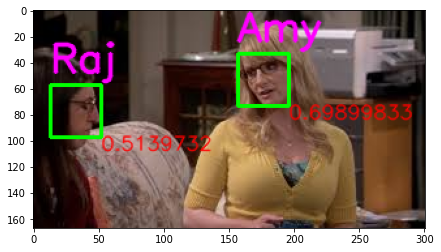

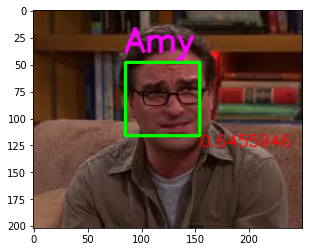

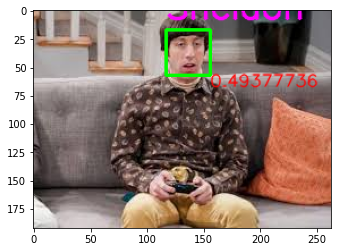

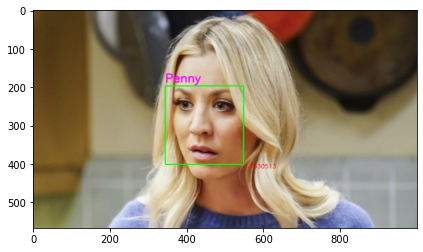

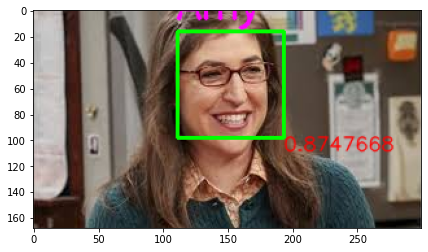

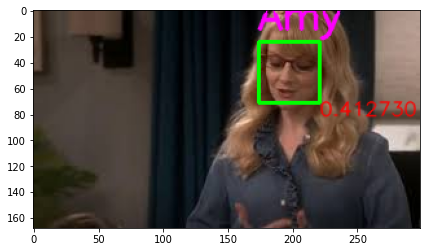

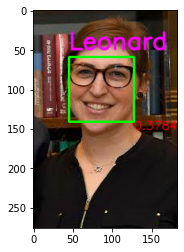

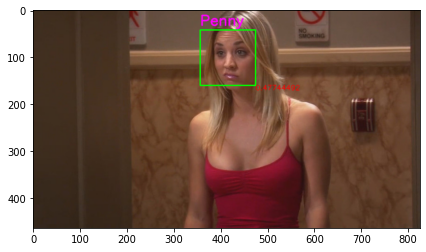

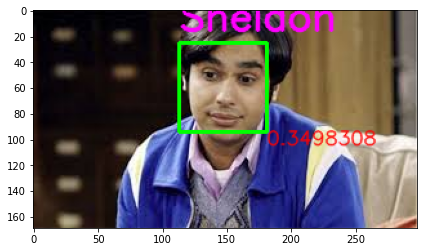

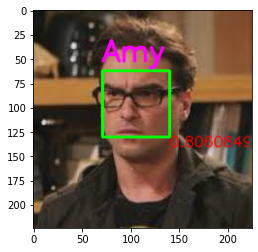

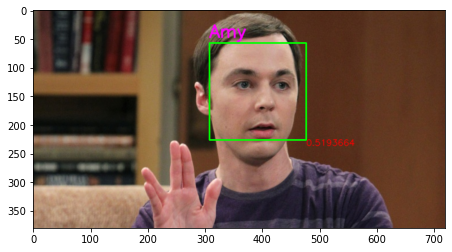

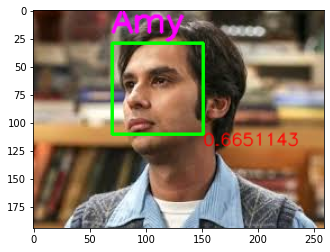

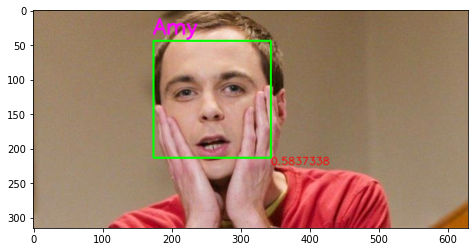

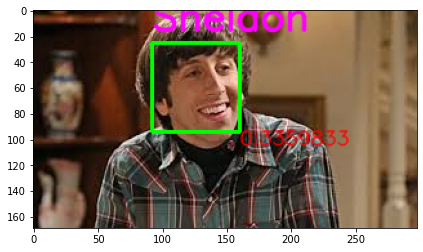

In [0]:
for img_name in os.listdir(path+'/test/'):
  if img_name=='crop_img.jpg':
    continue
  # Load Image
  img=cv2.imread(path+'/test/'+img_name)
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Detect Faces
  rects=dnnFaceDetector(gray,1)
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    # Extract Each Face
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
    width=right-left
    height=bottom-top
    img_crop=img[top:top+height,left:left+width]
    cv2.imwrite(path+'/test/crop_img.jpg',img_crop)
    
    # Get Embeddings
    crop_img=load_img(path+'/test/crop_img.jpg',target_size=(224,224))
    crop_img=img_to_array(crop_img)
    crop_img=np.expand_dims(crop_img,axis=0)
    crop_img=preprocess_input(crop_img)
    img_encode=custom_vgg_model(crop_img)

    # Make Predictions
    embed=K.eval(img_encode)
    person=classifier_model.predict(embed)
    name=person_rep[np.argmax(person)]
    os.remove(path+'/test/crop_img.jpg')
    cv2.rectangle(img,(left,top),(right,bottom),(0,255,0), 2)
    img=cv2.putText(img,name,(left,top-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    img=cv2.putText(img,str(np.max(person)),(right,bottom+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
  # Save images with bounding box,name and accuracy 
  cv2.imwrite(path+'/Predictions/'+img_name,img)
  plot(img)

Al ejecutar el ejemplo se carga la fotografía, se extrae el único rostro que sabemos que estaba presente, y luego se predice la identidad del rostro.



## Bibliografía
Narayana, L. (2019) *Face Recognition with VGG-Face in Keras.* Medium. Recuperado de: [aquí]( https://medium.com/analytics-vidhya/face-recognition-with-vgg-face-in-keras-96e6bc1951d5)

Iilkin, S. (2018) *Deep Face recognition with Keras* sefiks. Recuperado de: [aquí](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/)

